<a href="https://colab.research.google.com/github/usneek/sequence-embeddings/blob/main/SGT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code file has used SGT (Sequence Graph Transform) to generate sequence embeddings. SGT captures the long term and short term dependencies of events in a squence

### **Installation of SGT modeule** 

In [ ]:
pip install sgt


**Installing pandarallel labiraries to be used for multiprocessing**

In [ ]:
pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.5.2-py3-none-any.whl size=18398 sha256=42144cebee6c0e0ed68dfead46e747fcc74e82785e83c46d3bb7de9346195527
  Stored in directory: /root/.cache/pip/wheels/b5/6d/51/9ece2eaf007ea3f7fb0ce053c5773b2eb0d308887da3af12c1
Successfully built pandarallel


**Importing the required libraries**

In [ ]:
from sgt import SGT
import numpy as np
import pandas as pd
from itertools import chain
from itertools import product as iterproduct
import warnings
import pickle
########
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from pandarallel import pandarallel
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(7) # fix random seed for reproducibility

# **Preprocessing the data**

The steps required will be:-
1. To convert date of logs in YYYY-MM-DD fromat so they can be sorted in chronological order.
2. Next step is to fill empty cells in the column ModuleCode with Assessment Code
3. Then for each user we will create list of activities they attempted in order of date i.e. the sequence of activities.
4. Then we will remove those columns which don't have complete information about them i.e. if they passed or failed the course.
5. Then we will use LabelEncoder() to label the output values.
6. Finally we split the data into train, validation and test set in 3:1:1

In [ ]:
corpus=pd.read_csv("drive/MyDrive/Data/course_usage_anon.csv")
corpus['AttemptDate']=pd.to_datetime(corpus['AttemptDate'])
corpus=corpus.sort_values(by="AttemptDate")
corpus['ModuleCode'] = corpus['ModuleCode'].fillna(corpus['AssessmentCode'])


In [ ]:
x1=corpus.groupby(by="UserID")["ModuleCode"].apply(list)
x1=x1.reset_index(name="sequence")
x1.columns=["id","sequence"]

In [ ]:
corpus=corpus.dropna(subset=["PassFail"])
x2=corpus.groupby(by="UserID")["PassFail"].mean()
x2=x2.reset_index(name="PassFail")
x2.columns=["id","PassFail"]


In [ ]:
corpus=x1.join(x2,rsuffix='id',how="inner")

In [ ]:
y = corpus["PassFail"]
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

In [ ]:
x = corpus.loc[:,['id','sequence']]
corpus['sequence'] = corpus['sequence'].map(list)
print(x)

           id                                           sequence
0           1  [M2, M1, M3, M8, M13, M11, M16, M12, M3, M14, ...
1        1491  [M1, M2, M1, M1, M2, Medical Assistant (CCMA) ...
2        4918  [Medical Assistant (CCMA) Certification Practi...
3        5099  [Medical Assistant (CCMA) Certification Practi...
4        6858  [M6, M2, M4, M9, M16, M16, Medical Assistant (...
...       ...                                                ...
4770  1423499  [M5, M7, M5, M7, M2, M6, M1, Medical Assistant...
4771  1423500  [M2, M5, M16, M16, Medical Assistant (CCMA) Ce...
4772  1423523  [M1, Medical Assistant (CCMA) Certification Pr...
4773  1423530  [Medical Assistant (CCMA) Certification Practi...
4774  1423549                    [M6, M2, M2, M13, M13, M15, M2]

[4775 rows x 2 columns]


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,encoded_y,test_size=0.2,random_state=0)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=0)

# **Generating SGT sequence embedding**

In [ ]:
sgt_ = SGT(kappa=1, 
           lengthsensitive=False, 
           mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(x_train)
sgtembedding_df_2 = sgt_.fit_transform(x_val)
X = sgtembedding_df.set_index('id')
X_val=sgtembedding_df_2.set_index('id')

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


**A view of sequence embedding generated for each user**

In [ ]:
X

,"(M1, M1)","(M1, M10)","(M1, M11)","(M1, M12)","(M1, M13)","(M1, M14)","(M1, M15)","(M1, M16)","(M1, M17)","(M1, M2)","(M1, M3)","(M1, M4)","(M1, M5)","(M1, M6)","(M1, M7)","(M1, M8)","(M1, M9)","(M1, Medical Assistant (CCMA) Certification Practice Test 2.0 A)","(M1, Medical Assistant (CCMA) Certification Practice Test 2.0 B)","(M1, Medical Assistant (CCMA) Certification Practice Test 2.0 C)","(M10, M1)","(M10, M10)","(M10, M11)","(M10, M12)","(M10, M13)","(M10, M14)","(M10, M15)","(M10, M16)","(M10, M17)","(M10, M2)","(M10, M3)","(M10, M4)","(M10, M5)","(M10, M6)","(M10, M7)","(M10, M8)","(M10, M9)","(M10, Medical Assistant (CCMA) Certification Practice Test 2.0 A)","(M10, Medical Assistant (CCMA) Certification Practice Test 2.0 B)","(M10, Medical Assistant (CCMA) Certification Practice Test 2.0 C)",...,"(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M1)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M10)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M11)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M12)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M13)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M14)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M15)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M16)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M17)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M2)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M3)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M4)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M5)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M6)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M7)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M8)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, M9)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, Medical Assistant (CCMA) Certification Practice Test 2.0 A)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, Medical Assistant (CCMA) Certification Practice Test 2.0 B)","(Medical Assistant (CCMA) Certification Practice Test 2.0 B, Medical Assistant (CCMA) Certification Practice Test 2.0 C)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M1)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M10)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M11)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M12)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M13)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M14)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M15)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M16)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M17)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M2)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M3)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M4)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M5)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M6)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M7)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M8)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, M9)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, Medical Assistant (CCMA) Certification Practice Test 2.0 A)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, Medical Assistant (CCMA) Certification Practice Test 2.0 B)","(Medical Assistant (CCMA) Certification Practice Test 2.0 C, Medical Assistant (CCMA) Certification Practice Test 2.0 C)"
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1089484.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e

# **Evaluation**

1. We will train a classifier in keras to predict the output of each sequence embedding as pass/fail.
2. We will predict our accuracy and F1 score on test set to measure the efficeincy of our embeddings 

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape = (X.shape[1],))) 
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                25664     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [ ]:
model_checkpoint_callback = ModelCheckpoint(filepath='drive/MyDrive/Data/model.{epoch:02d}-{val_loss:.2f}.h5',
                                            save_weights_only = True,
                                            period = 1,
                                            verbose = 1,
                                            save_best_only=False)
history=model.fit(X, y_train ,validation_data=(X_val,y_val),batch_size=128, epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
24/24 [==============================] - 1s 15ms/step - loss: 0.6384 - accuracy: 0.7238 - val_loss: 0.5803 - val_accuracy: 0.7762

Epoch 00001: saving model to drive/MyDrive/Data/model.01-0.58.h5
Epoch 2/30
24/24 [==============================] - 0s 4ms/step - loss: 0.5872 - accuracy: 0.7598 - val_loss: 0.5433 - val_accuracy: 0.7762

Epoch 00002: saving model to drive/MyDrive/Data/model.02-0.54.h5
Epoch 3/30
24/24 [==============================] - 0s 3ms/step - loss: 0.5706 - accuracy: 0.7588 - val_loss: 0.5401 - val_accuracy: 0.7762

Epoch 00003: saving model to drive/MyDrive/Data/model.03-0.54.h5
Epoch 4/30
24/24 [==============================] - 0s 3ms/step - loss: 0.5624 - accuracy: 0.7595 - val_loss: 0.5388 - val_accuracy: 0.7762

Epoch 00004: saving model to drive/MyDrive/Data/model.04-0.54.h5
Epoch 5/30
24/24 [==============================] - 0s 4ms/step - loss: 0.5590 - accuracy: 0.7595 - val_loss: 0.5380 - val_accuracy: 0.7762

Epoch 00005: saving model to drive

**Plotting training and validation loss to decide the epoch number after which weights should be taken**

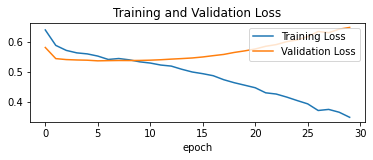

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Epoch no. is to be decided as 10**

In [ ]:
model.load_weights('drive/MyDrive/Data/model.10-0.54.h5')

**Predicting test score**

In [ ]:
sgt_ = SGT(kappa=1, 
           lengthsensitive=False, 
           mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(x_test)
X_test = sgtembedding_df.set_index('id')

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
predictions=model.predict(X_test)
rounded=[round(x[0]) for x in predictions]

In [ ]:
acc=accuracy_score(rounded,y_test)
f1=f1_score(y_test, rounded)
print("Accuracy is ",acc)
print("f1 score is ",f1)

Accuracy is  0.7643979057591623
f1 score is  0.8664688427299704


In [ ]:
model.save('embedding.h5')